# Bayesian Modeling and Computation in Python
## Chapter 3 - Pyro

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, NUTS, MCMC
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
from palmerpenguins import load_penguins

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
penguins = load_penguins()
penguins.dropna(how='any', axis=0, inplace=True)

In [3]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


## Pyro

In [4]:
adelie_mask = (penguins['species'] == 'Adelie')
adelie_mass_obs = torch.from_numpy(penguins.loc[adelie_mask, 'body_mass_g'].values)

### Code 3.3

In [67]:
def model_prior(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

In [68]:
# prior predictive check --> mu and sigma
prior_samples = Predictive(
    model_prior, {}, num_samples=1000, return_sites=['sigma', 'mu', 'mass'])(adelie_mass_obs)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/data/base.py:220: UserWarning: More chains (1000) than draws (146). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe40d891d00>]],
      dtype=object)

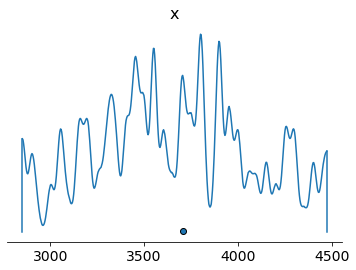

In [69]:
az.plot_density(data=prior_samples['mass'].numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe40d938490>]],
      dtype=object)

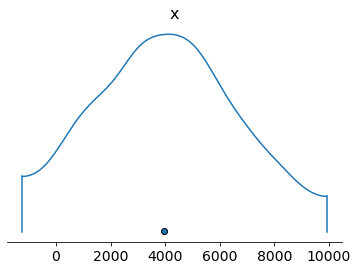

In [70]:
az.plot_density(data=prior_samples['mu'].numpy())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe40d986c10>]],
      dtype=object)

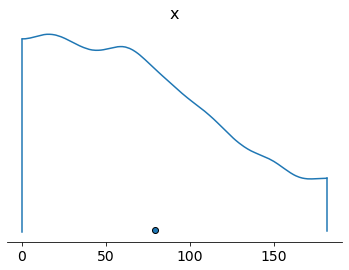

In [71]:
az.plot_density(data=prior_samples['sigma'].numpy())

In [39]:
def model(obs=None):
    # priors over params.
    sigma = pyro.sample('sigma', dist.HalfNormal(100., 2000.))
    mu = pyro.sample('mu', dist.Normal(4000, 3000))
    mass = pyro.sample('mass', dist.Normal(mu, sigma), obs=obs)

    return mass

In [40]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(obs=adelie_mass_obs)

Sample: 100%|██████████| 3000/3000 [00:38, 78.75it/s, step size=9.22e-01, acc. prob=0.914] 


In [7]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu   3706.26     35.61   3707.46   3644.90   3761.97   1820.74      1.00
     sigma    433.33     23.06    432.48    395.66    471.65   1112.60      1.00

Number of divergences: 0


In [8]:
samples_1 = mcmc.get_samples()

In [10]:
samples_1

{'mu': tensor([3761.4877, 3744.2118, 3708.0032,  ..., 3683.6709, 3713.1172,
         3619.1878], dtype=torch.float64),
 'sigma': tensor([417.8094, 422.2480, 436.3104,  ..., 455.0801, 415.7282, 437.3125],
        dtype=torch.float64)}

### Section 3.4.2

In [3]:
species_filter = penguins['species'].isin(['Adelie', 'Chinstrap'])
penguins = penguins[species_filter]

In [4]:
penguins['bill_length_mm'] = \
    (penguins['bill_length_mm'] - penguins['bill_length_mm'].mean()) / (penguins['bill_length_mm'].std())

In [5]:
penguins['sex_code'] = pd.Categorical(penguins['sex']).codes
penguins['species_code'] = pd.Categorical(penguins['species']).codes

In [6]:
penguins['species_code'].value_counts()

0    146
1     68
Name: species_code, dtype: int64

In [7]:
# design matrix
data = torch.tensor(
    penguins['bill_length_mm'].values, dtype=torch.float
    )

outcome = torch.tensor(
    penguins['species_code'].values, dtype=torch.float
    )

In [30]:
def model(bill_length, outcome=None):
    
    beta_0 = pyro.sample('beta_0', dist.Normal(0., 10.))
    beta_1 = pyro.sample('beta_1', dist.Normal(0., 10.))

    mu = beta_0 + bill_length * beta_1

    theta = pyro.deterministic('mu', torch.sigmoid(mu))
    db = pyro.deterministic('db', -beta_0 / beta_1)

    probs_species = pyro.sample('probs_species', dist.Bernoulli(theta), obs=outcome)


In [31]:
kernel = NUTS(model)

mcmc = MCMC(
    kernel,
    warmup_steps=1000,
    num_samples=3000
)

mcmc.run(data, outcome)

Sample: 100%|██████████| 4000/4000 [00:23, 167.44it/s, step size=6.99e-01, acc. prob=0.910]


In [33]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta_0     -2.25      0.48     -2.23     -3.02     -1.47   1116.03      1.00
    beta_1      6.03      1.01      5.96      4.45      7.62    990.57      1.00

Number of divergences: 0


In [35]:
coef = mcmc.get_samples(num_samples=5000)

In [36]:
coef

{'beta_0': tensor([-2.5377, -2.2180, -1.7581,  ..., -2.7042, -2.6922, -2.3471]),
 'beta_1': tensor([5.9295, 5.4665, 4.9583,  ..., 6.0508, 7.7903, 5.4161])}

In [52]:
az.from_pyro(
    posterior=mcmc
)

/Users/wastechs/opt/anaconda3/envs/probs/lib/python3.8/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data